# ALeRCE Extragalactic starter notebook

```Authors: Francisco Förster, Paula Sánchez-Sáez, Last updated: 20210405```

ALeRCE starter notebook for Extragalactic science using the ALeRCE client, and a direct database connection.

For more information about the ALeRCE broker, please visit http://alerce.science/, or read our publications:
* The Automatic Learning for the Rapid Classification of Events (ALeRCE) Alert Broker, [Förster et al. 2021, in press, AJ](https://arxiv.org/abs/2008.03303)
* Alert Classification for the ALeRCE Broker System: The Real-time Stamp Classifier, [Carrasco-Davis et al. 2021, submitted to AJ](https://arxiv.org/abs/2008.03309)
* Alert Classification for the ALeRCE Broker System: The Light Curve Classifier, [Sánchez-Sáez et al. 2021, AJ, 161, 141](https://ui.adsabs.harvard.edu/abs/2021AJ....161..141S/abstract)

Note that this notebook uses the ALeRCE Python client, which can be installed with pip (`pip install alerce`). For more information about this API and about the ALeRCE database visit http://alerce.science/.

# Table of contents:
* [ALeRCE client](#client)
* [Requirements](#req)
* [Simple functions to plot light curves using the client](#simplefunctions)
* [Query many AGN, QSO, and Blazar candidates using a direct DB connection](#agndb)
* [Query AGN, QSO, and Blazar features using a direct DB connection](#agndbother)

# ALeRCE client <a class="anchor" id="client"></a>

Install and import the alerce client

In [1]:
!pip install alerce

In [2]:
from alerce.core import Alerce
client = Alerce()

# Requirements <a class="anchor" id="req"></a>

Basic requirements 

In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import psycopg2
import json
import requests
from IPython.core.display import display, HTML

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [5]:
!pip install astroquery
from astroquery.ned import Ned
from astroquery.irsa_dust import IrsaDust

In [6]:
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from astropy.table import Table, Column
from astropy.coordinates import Distance
from astropy.cosmology import WMAP7

In [7]:
# color blind friendly green and red 
colors = {1: '#56E03A', 2: '#D42F4B'} 

# Using the client to get basic data and plot light curves  <a class="anchor" id="simplefunctions"></a>


Let's select a known Type Ia supernova and show it in the ALeRCE explorer 

In [8]:
oid = 'ZTF18acpfwmm'
display(HTML("<a href=\"https://alerce.online/object/%s\">%s</a>" % (oid, oid)))
# control-left click to open in new tab

### Basic object properties

In [9]:
client.query_objects(oid=oid, format='pandas')

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,g_r_mean,g_r_mean_corr,firstmjd,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
0,ZTF18acpfwmm,38,91,58440.423854,58493.277963,False,False,17,-0.127781,0.428657,-0.42193,0.524743,58440.517512,58493.277963,52.760451,112.802315,53.698235,0.00008,0.000041,None,None,None,corr_bulk_0.0.1


This table shows basic object statistics in one row per object, given by its unique identifier `oid`. Some of the properties shown are the coordinates `meanra`, `meandec`, colors at maximum `g_r_max`, or first and last detection times `firstmjd`, `lastmjd`.

### Basic band dependent statistics

Let's query basic objects properties and statistics per band

In [10]:
client.query_magstats(oid=oid, format='pandas')

,fid,stellar,corrected,ndet,ndubious,magmean,magmedian,magmax,magmin,magsigma,maglast,magfirst,firstmjd,lastmjd,step_id_corr
0,1,False,True,3,1,18.038502,18.222103,18.303806,17.589598,None,18.222103,18.303806,58443.527,58464.320,bulk_version_0.0.1
1,2,False,False,14,2,18.460432,18.453360,19.476646,17.717379,None,19.476646,19.457125,58440.516,58493.277,bulk_version_0.0.1


This table shows some band dependent statistics per object, with as many rows per object as bands available. The *g* and *r* bands are associated to unique filter ids `fid=1` and `fid=2`, respectively. Apart of some basic statistics per band, we also indicate wheter we believe the object is an isolated point source (`stellar`), whether we provide a reference corrected light curve (`corrected`), the number of detections associated to a given band (`ndet`), or whether some detections show possible inconsistencies when doing the correction (`ndubious`).

### Query detections

In [11]:
client.query_detections(oid, format="pandas").head()

,mjd,candid,fid,pid,diffmaglim,isdiffpos,nid,distnr,magpsf,magpsf_corr,magpsf_corr_ext,magap,magap_corr,sigmapsf,sigmapsf_corr,sigmapsf_corr_ext,sigmagap,sigmagap_corr,ra,dec,rb,rbversion,drb,magapbig,sigmagapbig,rfid,has_stamp,corrected,dubious,candid_alert,step_id_corr,phase,parent_candid
0,58440.517512,686517512615015030,2,686517512615,20.629270,1,686,1.525596,19.457125,NaN,None,19.2220,None,0.158149,NaN,NaN,0.1410,None,112.802267,53.698228,0.436667,t8_f5_c3,0.0,19.0107,0.1401,783120226,False,False,False,None,bulk_1.0.0,None,689422682615015005
1,58443.422685,689422682615015005,2,689422682615,20.114145,1,689,1.431517,18.422926,NaN,None,18.3295,None,0.065706,NaN,NaN,0.0915,None,112.802327,53.698224,0.653333,t8_f5_c3,0.0,18.2876,0.1094,783120226,False,False,False,None,bulk_1.0.0,None,689528702615015010
2,58443.528704,689528702615015010,1,689528702615,20.806282,1,689,1.387523,18.303806,17.065723,None,18.3407,None,0.048234,100.0,0.015421,0.0491,None,112.802364,53.698228,0.850000,t8_f5_c3,0.0,18.2917,0.0566,783120126,False,True,False,None,bulk_1.0.0,None,707518782615015003
3,58447.415405,693415402615015002,2,693415402615,19.465282,1,693,1.451031,17.893667,NaN,None,17.7614,None,0.067076,NaN,NaN,0.0709,None,112.802340,53.698237,0.730000,t8_f5_c3,0.0,17.7657,0.0896,783120226,False,False,False,None,bulk_1.0.0,None,720339622615015001
4,58447.503901,693503902615015005,2,693503902615,19.454613,1,693,1.576274,17.831804,NaN,None,17.9719,None,0.074578,NaN,NaN,0.0850,None,112.802301,53.698263,0.750000,t8_f5_c3,0.0,18.0974,0.1201,783120226,False,False,False,None,bulk_1.0.0,None,720339622615015001


You can see the entire light curve of the object, where every detection has a unique identifier `candid` and where time is given in Modified Julian Date `mjd`. The psf and aperture difference magnitudes (`magpsf` and `magap`), as well as their reference-corrected versions (`magpsf_corr` and `magap_corr`) are shown. The correcttion is only done when `distnr` < 1.4". We also show the difference image limiting magnitude (`diffmaglim`), whether the difference is positive or negative (`isdiffpos`), whether the detection has an associated stamp (`has_stamp`) and if not (some detections are only reported in subsequent alerts), what was the parent alert (`parent_candid`).

### Query non detections

In [12]:
client.query_non_detections(oid, format="pandas").head()

,mjd,fid,diffmaglim
0,58428.342893,1,20.8078
1,58431.460880,1,20.3734
2,58434.422095,1,20.3354
3,58434.443634,2,20.0710
4,58437.386100,2,20.3885


Here we see all the difference image limiting magnitudes reported for an object. Note that during ZTF phase I non-detections are only reported for the last 30 days before or at a given alert time. This means that if an object is reported only once, you will only see the previous non-detections. 

### Query probabilities

In [13]:
df = client.query_probabilities(oid, format='pandas')
df.loc[df.classifier_name.isin(['stamp_classifier', 'lc_classifier']) & (df.ranking==1)]

,classifier_name,classifier_version,class_name,probability,ranking
11,lc_classifier,hierarchical_random_forest_1.0.0,SNIa,0.425148,1
36,stamp_classifier,stamp_classifier_1.0.0,SN,0.724642,1


The `probability` table has very detailed information about the classification probabilities for a given object. It shows the classifier name, classifier version, class name, classification probability and classification ranking for **every** classified object, classifier name and version, and for all available classes for that particular classifier (the entire classification taxonomy). For simplicity, we select two particular classifiers and show only the most likely classes (`ranking=1`) for that object and classifier. In this case, the object was classified as SN by the stamp classifier and as SN Ia by the light curve classifier.

### Plot the image stamps

In [14]:
client.plot_stamps(oid)

We plotted the first image stamps associated to the given object. The convolutional neural network behind the stamp classifier was able to detect an extended source in the science and reference images and used this information to determine that this was most likely a SN object (an extragalactic transient).

### Plot the light curve

We will create two functions:
* `getSNdata`: get the light curve and additional data used to correct it such as the Milky Way attenuation and the redshift.
* `plotLC`: plot the light curve using all the information gathered by getSNdata.

In [15]:
def plotLC(oid, SN_det, SN_nondet, A=None, redshift=None):
    
    fig, ax = plt.subplots(figsize = (14, 7))
    labels = {1: 'g', 2: 'r'}
    markers = {1: 'o', 2: 's'}
    sizes = {1: 30, 2: 60}
    
    # distmod: distance modulus, reftime: reference time
    if redshift is not None:
        distmod = float(Distance(z=redshift, cosmology=WMAP7).distmod / u.mag)
        reftime = SN_det.mjd.loc[SN_det.magpsf.argmin()]
    else:
        distmod = 0
        reftime = 0
        redshift = 0
        
    # loop the passbands
    for fid in [1, 2]:
        
        # galactic extinction in the given band
        if A is not None:
            A_fid = A[labels[fid]]
        else:
            A_fid = 0

        # plot detections if available
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:
            
            # change time to restframe days if redshift is not zero
            times = (SN_det[mask].mjd - reftime) / (1. + redshift)
            
            # note that the detections index is candid and that we are plotting the psf corrected magnitudes
            if A_fid != 0:
                # plot attenuated light curve with small alpha
                ax.errorbar(times, SN_det[mask].magpsf - distmod, 
                    yerr=SN_det[mask].sigmapsf, c=colors[fid], marker=markers[fid], label=labels[fid], alpha=0.1)
                # show dust and distance attenuation corrected light curve
                ax.errorbar(times, SN_det[mask].magpsf - A_fid - distmod, 
                    yerr=SN_det[mask].sigmapsf, c=colors[fid], marker=markers[fid], label="%s (ext. corr.)" % labels[fid])
            else:
                # correct only for redshift
                ax.errorbar(times, SN_det[mask].magpsf - distmod, 
                    yerr=SN_det[mask].sigmapsf, c=colors[fid], marker=markers[fid], label=labels[fid])
        
        # plot non detections if available (and correct for dust and distance attenuation)
        mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        if np.sum(mask) > 0:     
            times = (SN_nondet[mask].mjd - reftime) / (1. + redshift)
            # non detections index is mjd
            ax.scatter(times, SN_nondet[mask].diffmaglim - A_fid - distmod, c = colors[fid], alpha = 0.5,
                marker='v', label="lim.mag. %s" % labels[fid], s=sizes[fid])
            
    # labels
    if A is not None and redshift != 0:
        ax.set_title("%s ($A_g=%.3f, A_r=%.3f$, z=%.4f)" % (oid, A["g"], A["r"], redshift))
    elif redshift != 0:
        ax.set_title("%s (z=%.4f)" % (oid, redshift))
    elif A is not None:
        ax.set_title("%s ($A_g=%.3f, A_r=%.3f$)" % (oid, A["g"], A["r"]))
    else:
        ax.set_title(oid)
        
    if redshift == 0:
        ax.set_xlabel("MJD")
        ax.set_ylabel("Apparent magnitude")
    else:
        ax.set_xlabel("Restframe time [days]")
        ax.set_ylabel("Absolute magnitude (no K-corr.)")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

In [16]:
def getSNdata(oid, doLC=False, doext=False, dostamp=False, doNED=False, doredshift=False):

    results = {"oid": oid}
    
    # query basic stats
    SN_stats = client.query_object(oid, format='pandas')
    results["stats"] = SN_stats
    
    # query detections
    SN_det = client.query_detections(oid, format='pandas')
    SN_det = SN_det.sort_values("mjd")
    results["lc_det"] = SN_det
        
    # query non detections
    SN_nondet = client.query_non_detections(oid, format='pandas')
    SN_nondet = SN_nondet.sort_values("mjd")
    results["lc_nondet"] = SN_nondet
    
    # object coordinates
    co = coordinates.SkyCoord(ra=float(SN_stats.meanra), dec=float(SN_stats.meandec), unit=(u.deg, u.deg), frame='icrs')
    
    # get galactic extinction
    if doext:
        # Galactic extinction (use SFD = D.J. Schlegel, D.P. Finkbeiner, & M. Davis (1998, ApJ, 500, 525))
        table = IrsaDust.get_extinction_table(co)
        A = {"g": float(table[table["Filter_name"] == "SDSS g"]["A_SFD"]), "r": float(table[table["Filter_name"] == "SDSS r"]["A_SFD"])}
        results["attenuation"] = A
    else:
        A = {"g": 0, "r": 0}

    # plot the LC
    if doLC:
        if doext:
            plotLC(oid, SN_det, SN_nondet, A)
        else:
            plotLC(oid, SN_det, SN_nondet)
            
    # find NED galaxies
    if doNED:
        Ned_table = Ned.query_region(co, radius=0.01 * u.deg, equinox='J2000.0')
        display(Ned_table)
        results["ned_table"] = Ned_table
        
        # save closest redshift if any
        df_ned = Ned_table.to_pandas()
        mask=df_ned.Redshift.notna()
        if mask.sum() > 0:
            results["redshift"] = df_ned.loc[df_ned.loc[mask].Separation.idxmin()].Redshift
            print("Redshift found: %s" % results["redshift"])
            
    # plot absolute magnitudes (without K-corrections)
    if doredshift:
        if type(doredshift) == float and doredshift > 0:
            results["redshift"] = doredshift
        if "redshift" in results.keys():
            if doext:
                plotLC(oid, SN_det, SN_nondet, A, results["redshift"])
            else:
                plotLC(oid, SN_det, SN_nondet, results["redshift"])            
    
    
    # show link
    display(HTML("<a href='http://alerce.online/object/%s' target=\"_blank\"> %s <a>" % (oid, oid)))

    # return data
    return results

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,str30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,WISEA J073109.69+534143.6,112.79039,53.69547,IrS,--,--,,,0.455,0,0,12,1,0,0,0
2,WISEA J073112.05+534203.2,112.79992,53.70097,G,--,--,,,0.185,0,0,27,3,0,2,0
3,WISEA J073112.21+534221.9,112.80091,53.70609,IrS,--,--,,,0.474,0,0,12,1,0,0,0
4,SN 2018iui,112.80233,53.69821,SN,--,--,,,0.001,1,0,0,1,0,0,0
5,WISEA J073112.64+534152.3,112.80271,53.69786,G,14781.0,0.049304,,,0.026,1,0,27,4,2,2,0
6,WISEA J073113.74+534201.8,112.80727,53.70051,IrS,--,--,,,0.223,0,0,12,1,0,0,0
7,WISEA J073115.75+534132.2,112.81565,53.69228,IrS,--,--,,,0.593,0,0,12,1,0,0,0


Redshift found: 0.049304


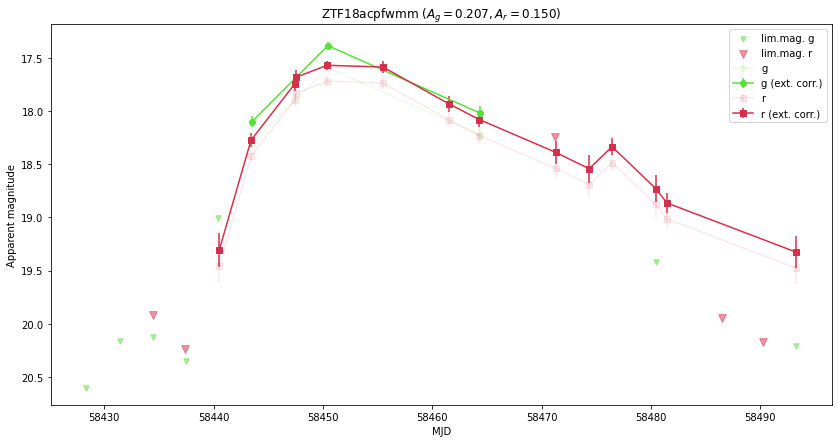

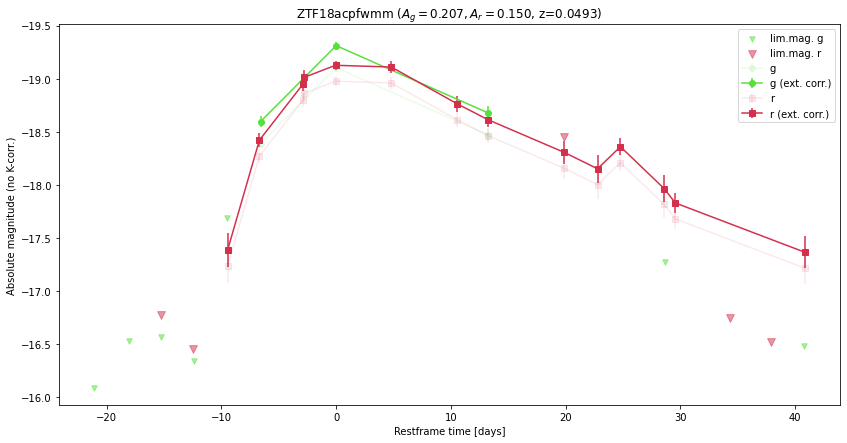

In [17]:
results = getSNdata(oid, doLC=True, doext=True, dostamp=True, doNED=True, doredshift=True);

We show three things: a table with NED crossmatches, from where we extract a redshift automatically; the apparent magnitude corrected and uncorrected by Milkly Way dust; and the absolute magnitude, assuming no K-corrections, against the restframe time from maximum. The peak magnitude is right where we expect it for a Type Ia Supernova.

### Querying features

The light curve classifier uses manually defined features to classify objects. The most important features for SN light curves are the parameters of a modified version of the Villar et al. 2019 SN parametric model. We use the following modification:

$$
\Large
F = \begin{cases}
        \cfrac{A \left(1 - \beta' \frac{t - t_0}{t_1 - t_0}\right)}{1 + \exp{\left(-\frac{t - t_0}{\tau_{\rm rise}}\right)}} & \mbox{if} \; t < t_1  \\ 
        \\
        \cfrac{A (1 - \beta') \exp{\left(-\frac{t - t_1}{\tau_{\rm fall}}\right)}}{1 + \exp{\left(-\frac{t - t_0}{\tau_{\rm rise}}\right)}} & \mbox{if} \; t \ge t_1,
  \end{cases}
$$

These parameters are stored as features with the SPM (Supernova Parametric Model) prefix. Let's get them for this SN:

In [18]:
features = client.query_features(oid, format='pandas')
features.head()

,name,value,fid,version
0,Amplitude,NaN,1,feature_0.0.1
1,Amplitude,0.879634,2,feature_0.0.1
2,AndersonDarling,NaN,1,feature_0.0.1
3,AndersonDarling,0.335959,2,feature_0.0.1
4,Autocor_length,NaN,1,feature_0.0.1


Let's look at the features starting with SPM

In [19]:
features.loc[features.name.apply(lambda row: row.startswith("SPM"))]

,name,value,fid,version
100,SPM_A,0.747551,1,feature_0.0.1
101,SPM_A,0.463471,2,feature_0.0.1
102,SPM_beta,0.892598,1,feature_0.0.1
103,SPM_beta,0.535324,2,feature_0.0.1
104,SPM_chi,NaN,1,feature_0.0.1
105,SPM_chi,0.308865,2,feature_0.0.1
106,SPM_gamma,15.407110,1,feature_0.0.1
107,SPM_gamma,15.274305,2,feature_0.0.1
108,SPM_t0,9.116030,1,feature_0.0.1
109,SPM_t0,2.864484,2,feature_0.0.1


Note that these features are organized per band, i.e. an independent fit is performed per band. Also note that if there are very few detections per band some of the fields may be NaN.

If you want to learn more about extragalactic transients with ALeRCE, please visit the following notebooks:
* https://github.com/alercebroker/usecases/blob/master/notebooks/ALeRCE_ZTF_Supernova.ipynb: detailed SN notebook, including complex queries to the database.
* https://github.com/alercebroker/usecases/blob/master/notebooks/ALeRCE_ZTF_forecasting_SNe.ipynb: forecasting API, which uses the SN parametric model to predict the magnitudes of SN light curves.
* https://github.com/alercebroker/usecases/blob/master/notebooks/ALeRCE_ZTF_watchlist.ipynb: watchlist for finding young SN around given locations in the sky.


You can install the following [Chrome extension](https://chrome.google.com/webstore/detail/open-in-colab/iogfkhleblhcpcekbiedikdehleodpjo?hl=en) or [Firefox extension](https://addons.mozilla.org/en-US/firefox/addon/open-in-colab/) to directly open them in Colab. 

# Query many AGN, QSO, and Blazar candidates using a direct DB connection <a class="anchor" id="agndb"></a>

We can query candidates using the ALeRCE client, which is good for relatively simple queries. However, if we want to do more complex queries the best solution may be to connect directly to the DB. We show how to do this here.

First you need to use the read only ALeRCE credentials available in the ALeRCE usecases github repository (https://github.com/alercebroker/usecases).

In [20]:
url = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json"
params = requests.get(url).json()['params']

In [21]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

The most relevant tables are, moving from less to more aggregation:

* `non_detection`: one row per non-detection per object, the limiting magnitudes
* `detection`: one row per detection, light curves and other relevant time dependent information
* `data_quality`: one row per detection, data quality related time dependent information
* `magstat`: one row per object per filter, statistics per bandpass per object
* `object`: one row per object, basic object statistics
* `probability`: one row per object per classifier and class, the probabilities of every object
* `reference`: one row per object per reference image, object statistics for every reference image used
* `feature`: one row per object per feature, object computed features
* `xmatch`: one row per object per external catalog, the table that points to the detailed xmatch tables
* `allwise, ps1_ztf, gaia_ztf, ss_stf`: one row per object, xmatch tables

The ALeRCE light curve classifier (Sánchez-Sáez et al. 2021) considers the following classes of active galaxies: 

* AGN: type 1 Seyfert galaxies (i.e., galaxies whose emission is dominated by the host galaxy), selected from MILLIQUAS (broad type "A"), and from Oh et al. 2015. 

* QSO: type 1 nucleus-dominated active galaxies (i.e., galaxies whose emission is dominated by their active nuclei), selected from MILLIQUAS (broad type "Q").

* Blazar: BL Lac objects and Flat Spectrum Radio Quasars (FSRQ), selected from ROMABZCAT and MILLIQUAS.

We can do a query asking for sources classfied as AGN, QSO or Blazar by the ALeRCE light curve classifier. We define a minimum number of detections (ndet), and a minimum time span between the first and the last detection (deltajd), in order to ensure the detection of a variable signal from the light curves.  We also filter out sources by their predicted class probability. WARNING: this might take some time to run...


In [22]:
query='''
SELECT
    object.oid, object.meanra, object.meandec, object.ndet,
    object.firstMJD, object.deltajd, object.g_r_mean_corr,
    probability_oid.classifier_name, probability_oid.class_name,
    probability_oid.ranking, probability_oid.probability
FROM
    object INNER JOIN (
    SELECT
        oid, classifier_name, class_name, ranking, probability
    FROM
        probability
    WHERE
        classifier_name='lc_classifier'
        AND class_name IN ('AGN', 'QSO', 'Blazar')
        AND probability > 0.5

    ) AS probability_oid
    ON object.oid=probability_oid.oid
WHERE
    probability_oid.classifier_name='lc_classifier'
    AND object.deltajd > 200
    AND object.ndet > 30
'''

objects = pd.read_sql_query(query, conn)
print(objects.shape)
objects.set_index('oid', inplace=True)
objects.head()

(24714, 11)


,meanra,meandec,ndet,firstmjd,deltajd,g_r_mean_corr,classifier_name,class_name,ranking,probability
oid,,,,,,,,,,
ZTF18acvtjlu,106.000655,34.140721,108,58895.158009,411.000440,0.100317,lc_classifier,QSO,1,0.569088
ZTF19aaadwqg,153.222200,56.873569,174,58580.218090,728.043970,0.205907,lc_classifier,QSO,1,0.613600
ZTF20aaxcwje,256.209851,48.376112,33,58941.493657,365.936643,NaN,lc_classifier,QSO,1,0.741324
ZTF19abeyxmu,357.580628,35.875529,77,58663.461829,566.697188,0.391540,lc_classifier,QSO,1,0.706624
ZTF19abypwkv,52.879835,-0.951153,34,58722.460498,534.669132,0.245700,lc_classifier,QSO,1,0.636956


How many sources are classified as QSOs, AGNs or Blazars?

In [23]:
print("QSO: ", len(objects.loc[objects["class_name"]=="QSO"]))
print("AGN: ", len(objects.loc[objects["class_name"]=="AGN"]))
print("Blazar: ", len(objects.loc[objects["class_name"]=="Blazar"]))


QSO:  16329
AGN:  6529
Blazar:  1856


We save the object IDs (oid) of each source, which will be used in the next sections:

In [24]:
oids_objects =  objects.index.values
print(len(oids_objects))
print(oids_objects)

24714
['ZTF18acvtjlu' 'ZTF19aaadwqg' 'ZTF20aaxcwje' ... 'ZTF20aapbhhj'
 'ZTF19aapunpm' 'ZTF20aaygrdz']


# Query AGN, QSO, and Blazar features using a direct DB connection <a class="anchor" id="agndbother"></a>

We will query some relevant features for active galaxies from the feature table, like GP_DRW_sigma and GP_DRW_tau, ExcessVar, and the Structure Function features. These features are described in detail in Sánchez-Sáez et al. 2021. WARNING: this might take some time to run...

In [25]:
query='''
SELECT
    *
FROM
    feature
WHERE
     oid in (%s)
''' % ",".join(["'%s'" % oid for oid in oids_objects])

features = pd.read_sql_query(query, conn)
features.head()

,oid,name,value,fid,version
0,ZTF17aaachjt,Amplitude,0.552537,1,feature_0.0.1
1,ZTF17aaachjt,Amplitude,0.457832,2,feature_0.0.1
2,ZTF17aaachjt,AndersonDarling,1.000000,1,feature_0.0.1
3,ZTF17aaachjt,AndersonDarling,0.999999,2,feature_0.0.1
4,ZTF17aaachjt,Autocor_length,3.000000,1,feature_0.0.1


Let's save these features in a new dataframe to make their manipulation easier 

In [26]:
features["fname"]=features.name + "_" + features.fid.astype(str)
features_aux = features.pivot(index="oid", columns="fname",values="value")
features_aux.head()

fname,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,Eta_e_1,Eta_e_2,ExcessVar_1,ExcessVar_2,GP_DRW_sigma_1,GP_DRW_sigma_2,GP_DRW_tau_1,GP_DRW_tau_2,Gskew_1,Gskew_2,Harmonics_mag_1_1,Harmonics_mag_1_2,Harmonics_mag_2_1,Harmonics_mag_2_2,Harmonics_mag_3_1,Harmonics_mag_3_2,Harmonics_mag_4_1,Harmonics_mag_4_2,Harmonics_mag_5_1,Harmonics_mag_5_2,Harmonics_mag_6_1,Harmonics_mag_6_2,Harmonics_mag_7_1,Harmonics_mag_7_2,Harmonics_mse_1,Harmonics_mse_2,Harmonics_phase_2_1,Harmonics_phase_2_2,Harmonics_phase_3_1,Harmonics_phase_3_2,...,g-r_max_12,g-r_max_corr_12,g-r_mean_12,g-r_mean_corr_12,gal_b_0,gal_l_0,iqr_1,iqr_2,last_diffmaglim_before_fid_1,last_diffmaglim_before_fid_2,last_mjd_before_fid_1,last_mjd_before_fid_2,max_diffmaglim_after_fid_1,max_diffmaglim_after_fid_2,max_diffmaglim_before_fid_1,max_diffmaglim_before_fid_2,mean_mag_1,mean_mag_2,median_diffmaglim_after_fid_1,median_diffmaglim_after_fid_2,median_diffmaglim_before_fid_1,median_diffmaglim_before_fid_2,min_mag_1,min_mag_2,n_det_1,n_det_2,n_neg_1,n_neg_2,n_non_det_after_fid_1,n_non_det_after_fid_2,n_non_det_before_fid_1,n_non_det_before_fid_2,n_pos_1,n_pos_2,positive_fraction_1,positive_fraction_2,r-W2_0,r-W3_0,rb_0,sgscore1_0
oid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZTF17aaachjt,0.552537,0.457832,1.000000,0.999999,3.0,2.0,0.288889,0.189189,0.00000,0.0,0.001646,0.010100,0.000246,1.073482e-04,1.160049e-01,7.917502e-02,90.416503,40.589192,0.170958,0.130886,70.084966,229.314395,57.489517,183.147115,40.564271,124.276526,24.062389,69.877720,11.672462,31.337920,4.335681,10.222251,0.979499,1.822567,0.011666,0.018858,3.154664,3.143477,0.043038,0.008687,...,0.222908,0.392540,0.526972,0.623955,-24.767803,186.928312,0.221476,0.193596,NaN,19.345501,NaN,58435.332031,20.941601,20.579201,NaN,19.345501,18.437954,17.813999,19.981601,19.823000,NaN,19.345501,17.805410,17.412870,45.0,74.0,7.0,4.0,70.0,43.0,0.0,1.0,38.0,70.0,0.844444,0.945946,NaN,NaN,0.872857,0.991310
ZTF17aaadhjr,0.588322,0.485362,1.000000,1.000000,4.0,16.0,0.195402,0.349515,0.00000,0.0,0.006343,0.000606,0.000367,3.847144e-04,1.451344e-01,1.189809e-01,19.760977,30.264028,0.018673,0.251896,1.169223,1.357168,1.025672,1.147934,1.012167,0.948059,0.862254,0.696804,0.561094,0.467039,0.296354,0.225692,0.129065,0.111239,0.052088,0.044924,5.820257,3.585293,5.628890,0.681972,...,0.187309,0.357458,0.195022,0.390052,18.070586,201.846480,0.330764,0.540666,18.866600,NaN,58474.503906,NaN,20.939600,20.665899,20.355499,NaN,17.050534,16.660482,20.256500,19.883900,18.866600,NaN,16.069096,15.711637,87.0,103.0,11.0,47.0,37.0,49.0,5.0,0.0,76.0,56.0,0.873563,0.543689,NaN,NaN,0.923571,1.000000
ZTF17aaaeqnq,0.169636,0.121363,1.000000,0.999997,5.0,10.0,0.277108,0.301370,0.02439,0.0,0.511526,0.160036,0.000015,1.119375e-05,3.449542e-02,2.718389e-02,1237.638696,1058.479908,-0.131905,-0.078398,0.110009,0.083643,0.117408,0.086471,0.070841,0.043055,0.036106,0.030254,0.027371,0.017702,0.028691,0.034433,0.042758,0.020770,0.001675,0.001027,2.800516,2.395459,0.376819,5.507020,...,0.549171,0.682959,0.603916,0.735875,-30.455058,129.797429,0.063645,0.073598,20.975901,20.273600,58370.367188,58432.277344,21.053101,20.864300,21.117599,20.849600,17.050879,16.315004,20.246599,20.114901,21.021900,20.404699,16.786095,16.103136,166.0,146.0,158.0,142.0,157.0,163.0,8.0,11.0,8.0,4.0,0.048193,0.027397,NaN,NaN,0.885000,0.358054
ZTF17aaafvek,0.076501,0.072550,0.987001,0.440283,1.0,1.0,0.333333,0.250000,0.00000,0.0,0.985172,0.360739,-0.000003,-5.229952e-06,4.537258e-05,4.010096e-09,0.329470,9.012482,0.012838,-0.004001,0.028834,0.010207,0.043291,0.002752,0.051591,0.027940,0.018757,0.016519,0.034571,0.031514,0.038257,0.012899,0.016315,0.015894,0.000431,0.000660,3.856020,5.565102,2.872672,4.626267,...,0.281099,0.222507,0.389963,0.217055,-65.060965,175.378264,0.022745,0.036535,20.545300,20.546301,58701.460938,58695.464844,20.655399,20.413500,20.609301,20.

In [27]:
objects = objects.join(features_aux)
objects.head()

,meanra,meandec,ndet,firstmjd,deltajd,g_r_mean_corr,classifier_name,class_name,ranking,probability,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,Eta_e_1,Eta_e_2,ExcessVar_1,ExcessVar_2,GP_DRW_sigma_1,GP_DRW_sigma_2,GP_DRW_tau_1,GP_DRW_tau_2,Gskew_1,Gskew_2,Harmonics_mag_1_1,Harmonics_mag_1_2,Harmonics_mag_2_1,Harmonics_mag_2_2,Harmonics_mag_3_1,Harmonics_mag_3_2,Harmonics_mag_4_1,Harmonics_mag_4_2,Harmonics_mag_5_1,Harmonics_mag_5_2,...,g-r_max_12,g-r_max_corr_12,g-r_mean_12,g-r_mean_corr_12,gal_b_0,gal_l_0,iqr_1,iqr_2,last_diffmaglim_before_fid_1,last_diffmaglim_before_fid_2,last_mjd_before_fid_1,last_mjd_before_fid_2,max_diffmaglim_after_fid_1,max_diffmaglim_after_fid_2,max_diffmaglim_before_fid_1,max_diffmaglim_before_fid_2,mean_mag_1,mean_mag_2,median_diffmaglim_after_fid_1,median_diffmaglim_after_fid_2,median_diffmaglim_before_fid_1,median_diffmaglim_before_fid_2,min_mag_1,min_mag_2,n_det_1,n_det_2,n_neg_1,n_neg_2,n_non_det_after_fid_1,n_non_det_after_fid_2,n_non_det_before_fid_1,n_non_det_before_fid_2,n_pos_1,n_pos_2,positive_fraction_1,positive_fraction_2,r-W2_0,r-W3_0,rb_0,sgscore1_0
oid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ZTF18acvtjlu,106.000655,34.140721,108,58895.158009,411.000440,0.100317,lc_classifier,QSO,1,0.569088,0.115128,0.094167,0.679438,0.653548,2.0,1.0,0.241935,0.282051,0.0,0.0,0.616774,0.405598,-0.000009,-0.000009,9.532727e-04,1.422519e-08,25.551217,13.766602,0.045384,0.015785,0.045713,0.035888,0.020227,0.008385,0.015513,0.009404,0.013852,0.023922,0.014392,0.011770,...,-0.182463,0.091850,-0.105459,0.096275,17.233956,182.845023,0.086856,0.070203,19.429100,20.1833,58890.308594,59116.421875,20.876900,20.726601,20.650101,20.620001,19.172040,19.075765,19.515800,19.954201,20.124650,20.15625,19.058531,18.966681,62.0,39.0,62.0,39.0,51.0,79.0,6.0,28.0,0.0,0.0,0.0,0.0,NaN,NaN,0.891429,0.946417
ZTF19aaadwqg,153.222200,56.873569,174,58580.218090,728.043970,0.205907,lc_classifier,QSO,1,0.613600,0.152372,0.129358,0.861386,0.994001,2.0,5.0,0.264151,0.300000,0.0,0.0,0.639624,1.101772,-0.000002,-0.000002,7.527645e-03,2.949972e-03,845.176164,672.485199,0.059455,0.077562,1.884968,0.068104,1.950022,0.042132,1.286387,0.037869,0.671610,0.064870,0.779684,0.032525,...,0.028002,0.154814,0.011162,0.204981,49.149823,155.139505,0.104532,0.104807,20.463301,19.6271,58597.257812,58575.222656,21.153999,20.729601,20.889099,19.882099,18.908845,18.703864,20.193199,19.564600,20.190399,19.62710,18.733263,18.578449,53.0,110.0,53.0,110.0,133.0,114.0,13.0,3.0,0.0,0.0,0.0,0.0,NaN,NaN,0.894286,0.980833
ZTF20aaxcwje,256.209851,48.376112,33,58941.493657,365.936643,NaN,lc_classifier,QSO,1,0.741324,0.066587,NaN,0.999760,NaN,1.0,NaN,0.187500,NaN,0.0,NaN,1.663877,NaN,-0.000002,NaN,5.437000e-05,NaN,109.243863,NaN,0.051783,NaN,0.014990,NaN,0.014340,NaN,0.007131,NaN,0.009910,NaN,0.015947,NaN,...,NaN,NaN,NaN,NaN,37.301864,74.658212,0.031847,NaN,19.932199,NaN,58940.468750,NaN,21.165899,NaN,19.932199,NaN,18.514591,NaN,20.069950,NaN,19.577450,NaN,18.457178,NaN,32.0,NaN,32.0,NaN,46.0,NaN,2.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.877857,1.000000
ZTF19abeyxmu,357.580628,35.875529,77,58663.461829,566.697188,0.391540,lc_classifier,QSO,1,0.706624,0.174949,NaN,0.992810,NaN,1.0,NaN,0.200000,NaN,0.0,NaN,1.091892,NaN,0.000000,NaN,0.000000e+00,0.000000e+00,0.995360,0.977559,0.208717,NaN,281.149411,1.913418,383.995009,1.844951,382.822427,4.986334,301.789553,2.946406,178.139483,1.856934,...,-0.225195,0.327564,0.038433,0.384375,-25.368766,109.262875,0.136549,0.062560,20.465200,20.8132,58666.477407,58697.434306,21.044100,20.932899,20.566000,20.859600,20.008016,19.623640,20.196701,20.227350,20.201000,20.56460,19.911051,19.583487,15.0,4.0,15.0,4.0,86.0,88.0,6.0,11.0,0.0,0.0,0.0,0.0,NaN,NaN,0.900000,0.994375
ZTF19abypwkv,52.879835,-0.951153,34,58722.460498,534.669132,0.245700,lc_classifier,QSO,1,0.636956,0.072034,0.065631,0.333667,0.799426,1.0,1.0,0.235294,

Now let's see the distribution of the Damp Random Walk (DRW) parameters.  A DRW model is defined by a stochastic differential equation which includes a damping term that pushes the signal back to its mean: $dX(t)=-\frac{1}{\tau_{DRW}}X(t)dt+\sigma_{DRW}\sqrt{dt}\,\epsilon(t)+b\,dt,    \quad      \tau_{DRW},\sigma_{DRW},t>0$.  $\tau_{DRW}$ corresponds to the characteristic time for the time series to become roughly uncorrelated, $\sigma_{DRW}$ corresponds to the amplitude of the variability at short timescales ($t \ll \tau_{DRW}$), and $\epsilon(t)$ is a white noise process with zero mean and variance equal to 1. DRW modelling is typically used to describe light curves of active galactic nuclei ([Kelly et al. 2009](https://ui.adsabs.harvard.edu/abs/2009ApJ...698..895K/abstract)). In this case we obtained the $\sigma_{DRW}$ and $\tau_{DRW}$ parameters using Gaussian process regression, with a Ornstein-Uhlenbeck kernel, as in [Graham et al. 2017](https://ui.adsabs.harvard.edu/abs/2017MNRAS.470.4112G/abstract). GP\_DRW\_sigma denote $\sigma_{DRW}$, while GP\_DRW\_tau denote  $\tau_{DRW}$.


Below we plot the distribution of GP\_DRW\_tau and GP\_DRW\_sigma in the $g$ band, for QSOs, AGNs, and Blazars. 

(-4.5, 0.3)

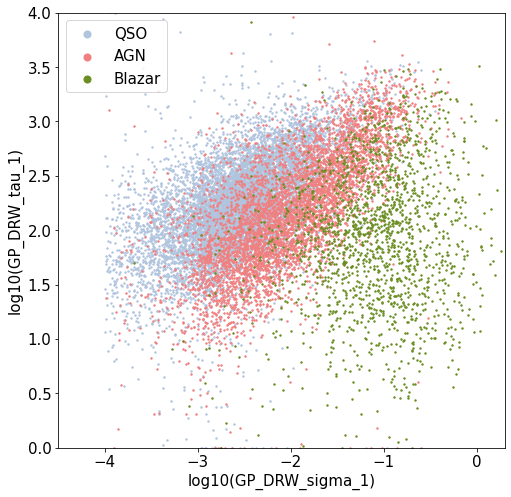

In [28]:
feature_x='GP_DRW_sigma_1'
feature_y='GP_DRW_tau_1'

fig, ax = plt.subplots(figsize = (8,8)) 

objects_aux = objects[(objects[feature_x]>=1e-4) & (objects[feature_y]>=1)] # we want to avoid incorrect measurements 

for class_name, color in [("QSO","lightsteelblue"),("AGN","lightcoral"),("Blazar","olivedrab")]:
  plt.scatter(np.log10(objects_aux.loc[objects_aux["class_name"]==class_name,feature_x].values),np.log10(objects_aux.loc[objects_aux["class_name"]==class_name,feature_y].values),c=color,s=2,label=class_name)


plt.ylabel("log10(%s)" % (feature_y),fontsize=15)
plt.xlabel("log10(%s)" % (feature_x),fontsize=15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15,markerscale=5)
plt.ylim(0,4)
plt.xlim(-4.5,0.3)

It can be seen that QSOs, AGNs, and Blazars occupy different locations in this plot, with Blazars showing larger values of GP\_DRW\_sigma\_1. This behavior was also found in a previous analysis presented by [Ruan et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...760...51R/abstract).

If you want to learn more about active galaxies with ALeRCE, please visit the following notebook:
* https://github.com/alercebroker/usecases/blob/master/notebooks/ALeRCE_ZTF_ActiveGalaxies.ipynb: detailed AGN notebook, including examples on how to use the ALeRCE client, and complex queries to the database.